In [22]:
# https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch
# https://www.kaggle.com/abhishekgbhat/eda-cnn-architecture-tuning-80-83-accuracy

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os,cv2,itertools
from glob import glob
import seaborn as sns
from PIL import Image
from tqdm import tqdm

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms


In [24]:
# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

sns.set(color_codes = True)
#Global Variables
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [25]:
data_dir = '../fl_ham/input'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [26]:
print(os.listdir(data_dir))
# number of image path,
# image id path dict
print('all image path',len(all_image_path))
print('all image id path',len(imageid_path_dict))

['hmnist_8_8_L.csv', 'ham10000_images_part_2', 'HAM10000_images_part_2', 'ham10000_images_part_1', 'hmnist_28_28_RGB.csv', 'HAM10000_metadata.csv', 'saved_data', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_L.csv', 'HAM10000_images_part_1']
all image path 20030
all image id path 10015


In [27]:
all_image_path[0]

'../fl_ham/input/ham10000_images_part_2/ISIC_0034058.jpg'

In [28]:
# we're now processing with cv2 module
# Note that cv2 read image as BGR. 
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

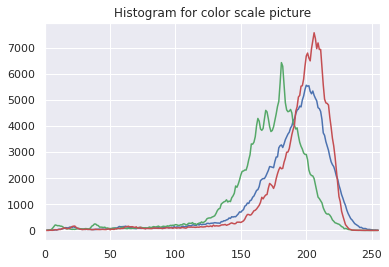

In [29]:
img = cv2.imread(all_image_path[0], -1)
# cv2.imshow('GoldenGate',img)
color = ('b','g','r')
for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Histogram for color scale picture')
plt.show()

In [14]:
img = cv2.imread(all_image_path[0], -1) # -1 flag means unchanged
img.shape
img = cv2.resize(img, (224,224))
img.shape

(224, 224, 3)

In [ ]:
cv2.show('GoldenGate',img)

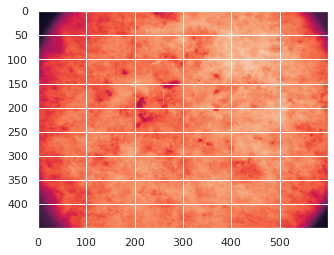

In [30]:
gray_img = cv2.imread(all_image_path[0], cv2.IMREAD_GRAYSCALE)
gray_img.shape
plt.imshow(gray_img)
plt.show()

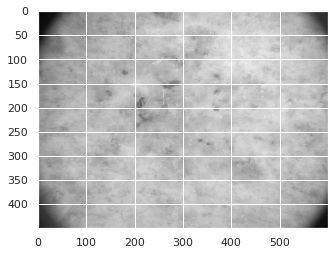

In [36]:
# https://stackoverflow.com/questions/43157949/opencv-convert-to-grayscale-not-working-properly
# https://github.com/mafls122/python_openCV/blob/main/openCV_02.py
# https://davey.tistory.com/entry/Python-opencv-%EC%9D%B4%EC%9A%A9%ED%95%98%EC%97%AC-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%83%89%EC%83%81-%ED%9D%91%EB%B0%B1%EC%9C%BC%EB%A1%9C-%EB%B0%94%EA%BE%B8%EA%B8%B0
gray_img = cv2.imread(all_image_path[0])
gray_test = cv2.cvtColor(gray_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_test, cmap='gray', vmin=0,vmax=255)
plt.show()

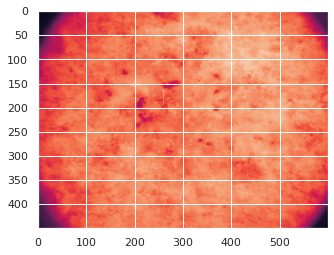

In [38]:
img3 = cv2.imread(all_image_path[0])
img3_gray = (0.299 * img3[:, :, 2]) + (0.587 * img3[:, :, 1]) + (0.114 * img3[:, :, 0])
plt.imshow(img3_gray)
plt.show()

In [41]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../fl_ham/input/HAM10000_images_part_1/ISIC_00...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../fl_ham/input/HAM10000_images_part_1/ISIC_00...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../fl_ham/input/HAM10000_images_part_1/ISIC_00...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../fl_ham/input/HAM10000_images_part_1/ISIC_00...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../fl_ham/input/HAM10000_images_part_2/ISIC_00...,Benign keratosis-like lesions,2


In [42]:
df_original.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [43]:
df_original.age.describe()

count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64

In [46]:
df_original["age"].fillna(df_original.age.median(), inplace = True)

In [47]:
df_original.age.describe()

count    10015.000000
mean        51.853220
std         16.920833
min          0.000000
25%         40.000000
50%         50.000000
75%         65.000000
max         85.000000
Name: age, dtype: float64

In [48]:
df_original.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [49]:
df_original.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx'],
      dtype='object')

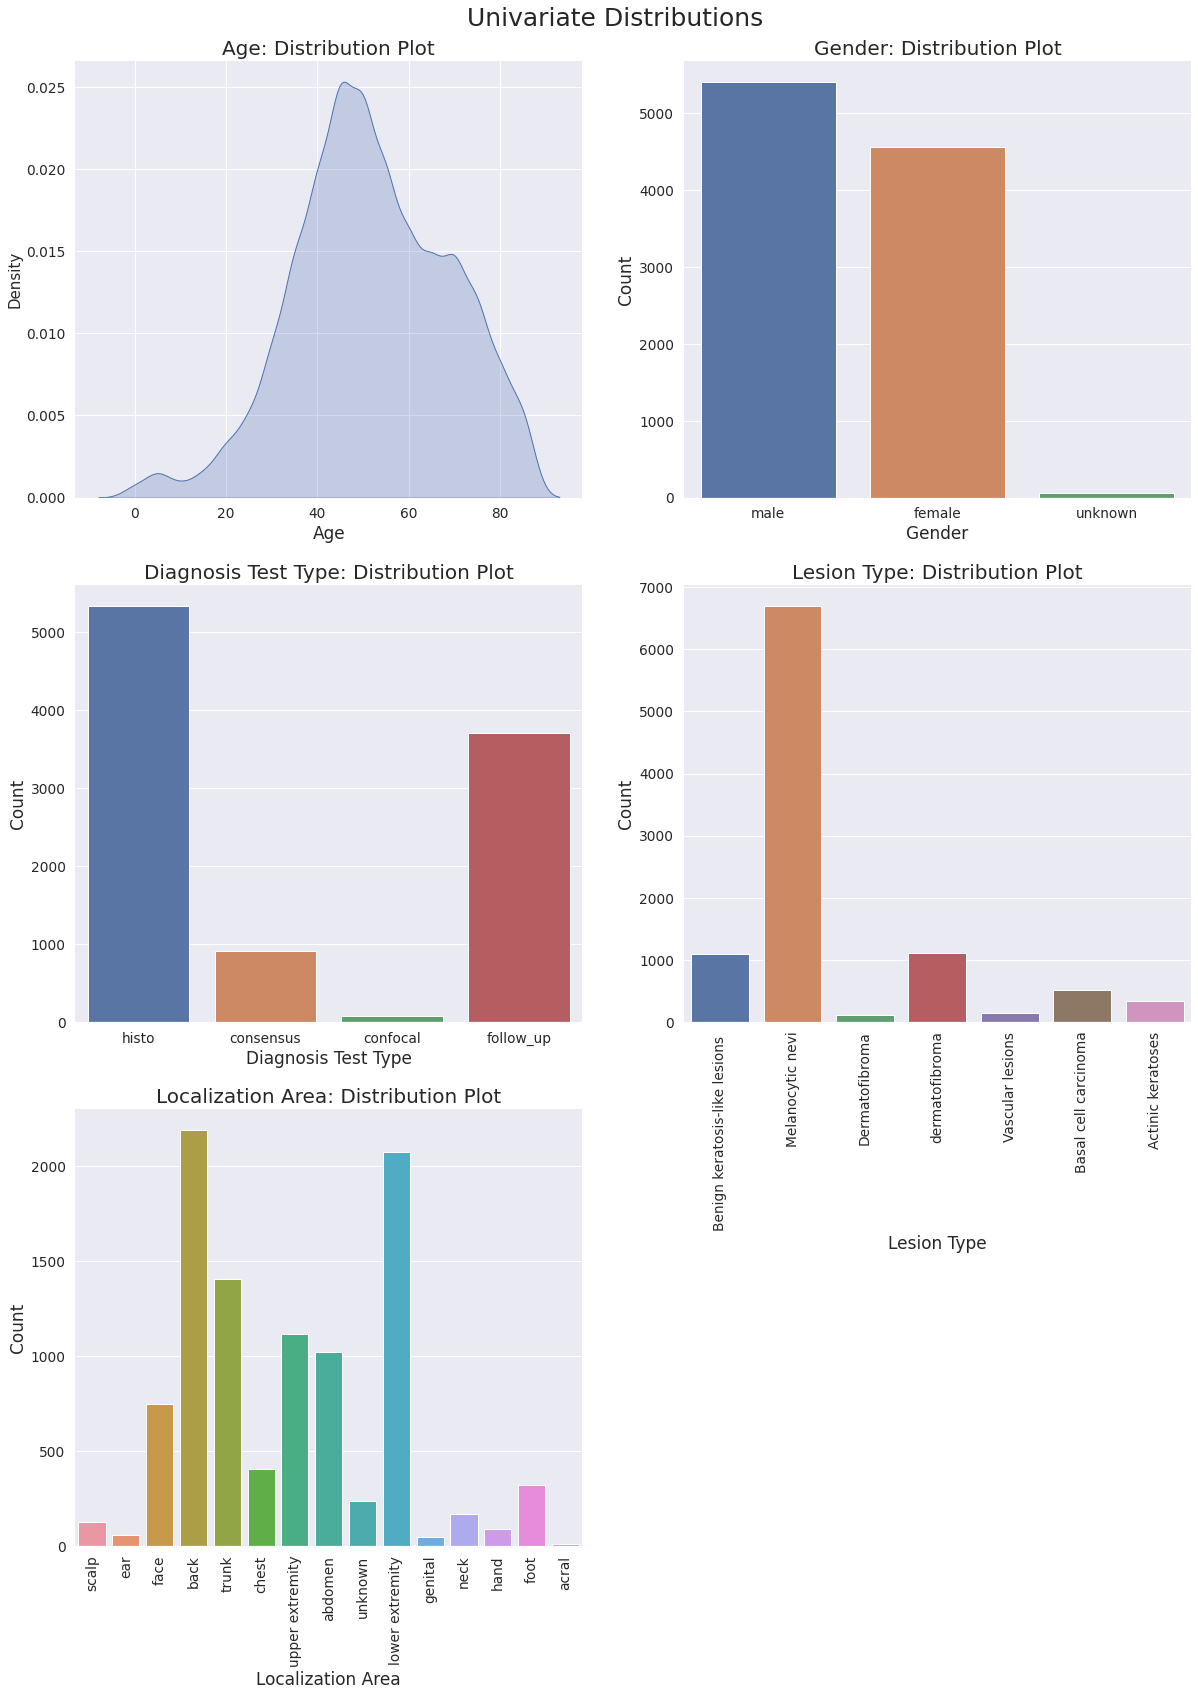

In [51]:
# EDA
sns.set(font_scale = 1.25)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 2, figsize=(20, 25))
sns.despine(left=True)

# Age distribution
sns.kdeplot(df_original["age"], legend = False, shade = True, ax=axes[0, 0])
axes[0,0].set_xlabel("Age", fontsize=17)
axes[0,0].set_title("Age: Distribution Plot", fontsize=20)

# Gender distribution
sns.countplot(x = "sex", data = df_original, ax=axes[0, 1])
axes[0,1].set_xlabel("Gender", fontsize=17)
axes[0,1].set_title("Gender: Distribution Plot", fontsize=20)
axes[0,1].set_ylabel("Count", fontsize=17)

# Diagnosis Test type distribution
sns.countplot(x = "dx_type", data = df_original, ax=axes[1, 0])
axes[1,0].set_xlabel("Diagnosis Test Type", fontsize=17)
axes[1,0].set_ylabel("Count", fontsize=17)
axes[1,0].set_title("Diagnosis Test Type: Distribution Plot", fontsize=20)

# Lesion type distribution
sns.countplot(x = "cell_type", data = df_original, ax=axes[1, 1])
axes[1,1].set_xlabel("Lesion Type", fontsize=17)
axes[1,1].set_ylabel("Count", fontsize=17)
axes[1,1].set_title("Lesion Type: Distribution Plot", fontsize=20)

## Lesion type distribution
sns.countplot(x = "localization", data = df_original, ax=axes[2, 0])
axes[2,0].set_xlabel("Localization Area", fontsize=17)
axes[2,0].set_ylabel("Count", fontsize=17)
axes[2,0].set_title("Localization Area: Distribution Plot", fontsize=20)

c = 0
for ax in f.axes:
    c+=1
    if c<=3:
        continue
    plt.sca(ax)
    plt.xticks(rotation=90)
    
plt.subplots_adjust(top=0.95)
f.suptitle('Univariate Distributions', fontsize=25)
f.delaxes(axes[2,1]) 

In [52]:
# Lesion type Melanocytic nevi has maximum count.
# Majority of the images are from the following regions: back, lower extremity and trunk.

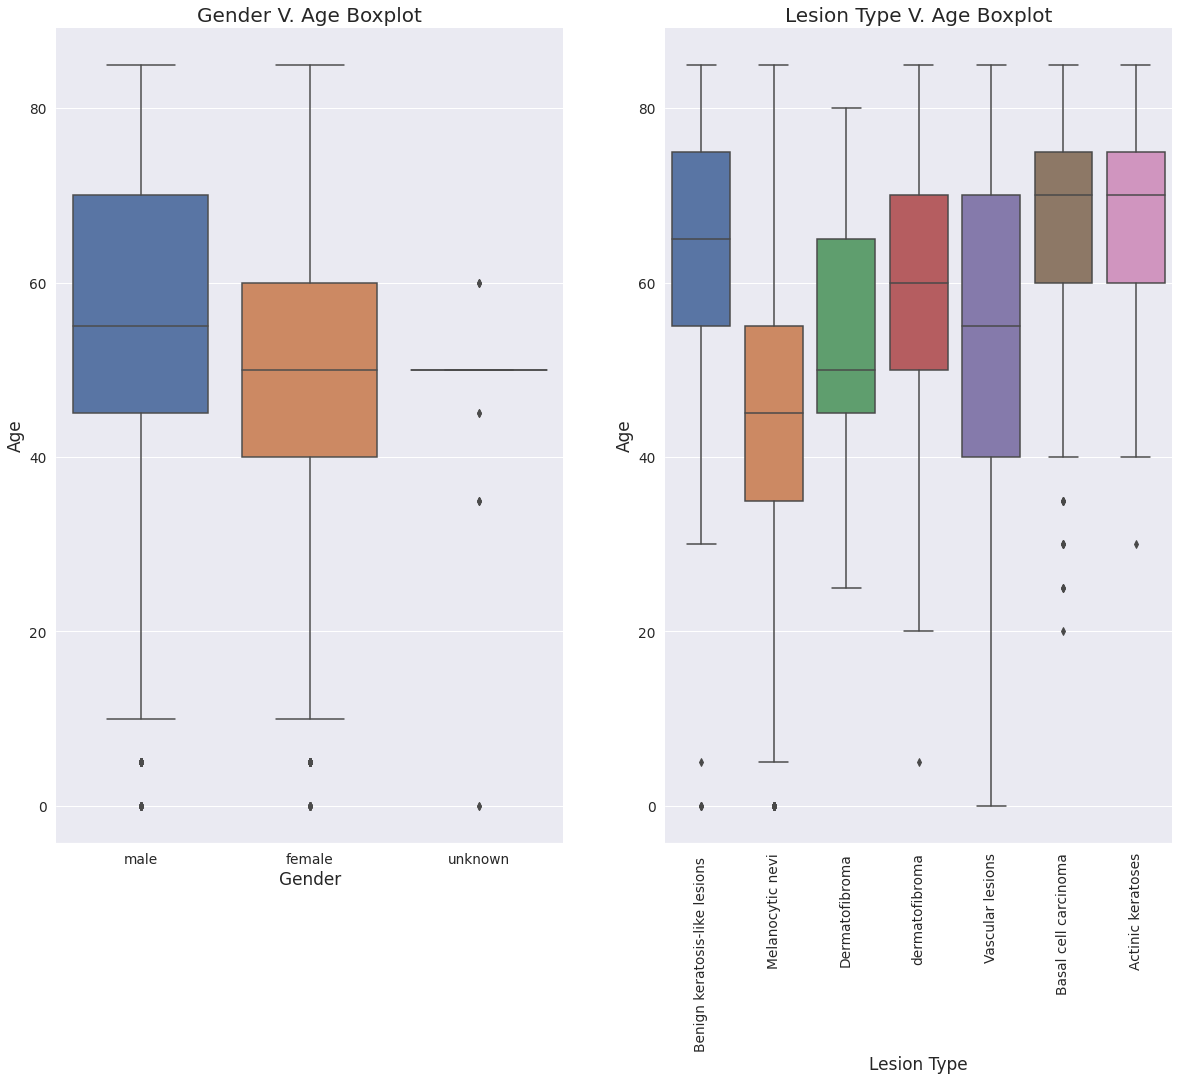

In [54]:
sns.set(font_scale = 1.25)

# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(20, 15))
sns.despine(left=True)

# Gender distribution
sns.boxplot(x = "sex", y = "age", data = df_original, ax=axes[0])
axes[0].set_xlabel("Gender", fontsize=17)
axes[0].set_ylabel("Age", fontsize=17)
axes[0].set_title("Gender V. Age Boxplot", fontsize=20)

# Lesion distribution
sns.boxplot(x = "cell_type", y = "age", data = df_original, ax=axes[1])
axes[1].set_xlabel("Lesion Type", fontsize=17)
axes[1].set_ylabel("Age", fontsize=17)
axes[1].set_title("Lesion Type V. Age Boxplot", fontsize=20)

c = 0
for ax in f.axes:
    c+=1
    if c<=1:
        continue
    plt.sca(ax)
    plt.xticks(rotation=90)

In [56]:
%%time
df_original['image'] = df_original['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

CPU times: user 2min 29s, sys: 1.42 s, total: 2min 30s
Wall time: 2min 30s


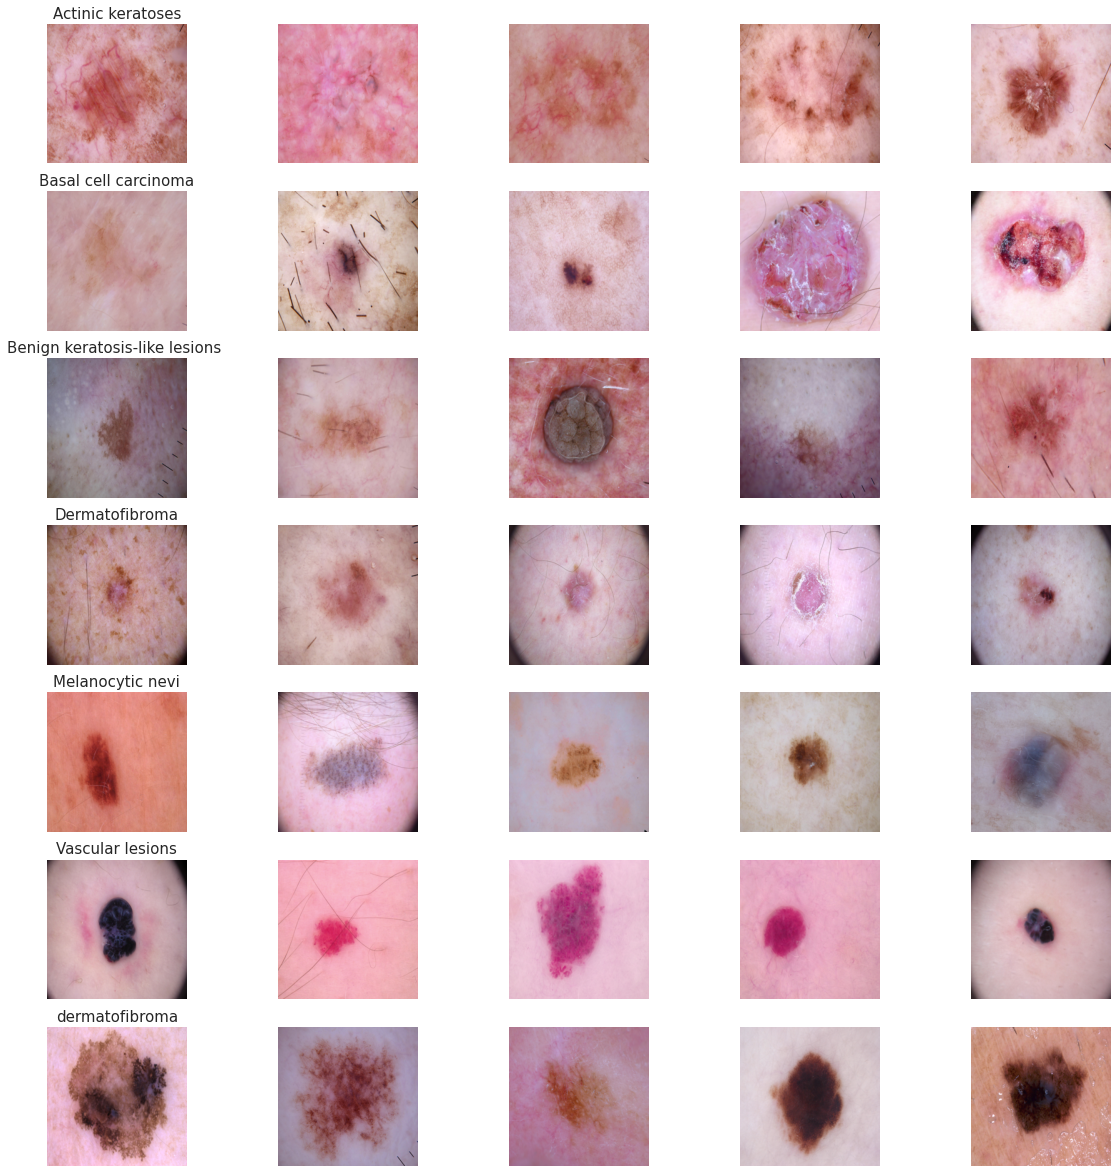

In [57]:
# Image Visualization
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df_original.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

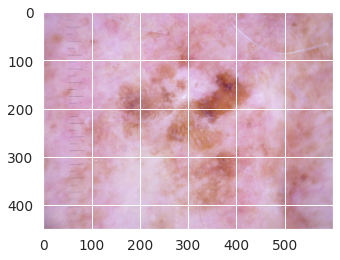

In [61]:
img = cv2.imread('../fl_ham/input/ham10000_images_part_1/ISIC_0027419.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

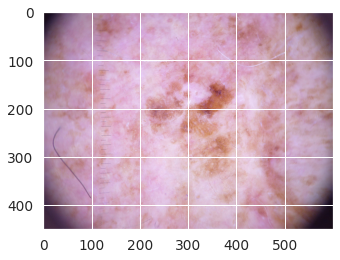

In [63]:
img = cv2.imread('../fl_ham/input/ham10000_images_part_1/ISIC_0025030.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [66]:
no_image_df = df_original.drop(columns =['image'])

In [69]:
df_undup = no_image_df.groupby('lesion_id').count()

In [72]:
len(df_undup)

7470

In [73]:
len(no_image_df)

10015

In [74]:
df_undup.head()

,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
lesion_id,,,,,,,,,
HAM_0000000,2,2,2,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1,1,1,1
